In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import yaml
import pprint
import os
import time
import numpy as np
# weights and biases for tracking of metrics
import wandb 
# make the plots inline again
%matplotlib inline
# sometimes have to activate this to plot plots in notebook
# matplotlib.use('Qt5Agg')
from code import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def log_surface_hypersphere(n_dim_sphere, r=1):
    """
    n_dim_sphere of the sphere embedded in the n+1 dimensional Euclidean space
    
    Calculate surface in log space for numerical stability. Work with log gamma function for numerical stability.
    """
    
    s1 = (n_dim_sphere + 1) / 2 * torch.log(torch.tensor(math.pi)) + torch.log(torch.tensor(2.))
    
    s2 = - torch.lgamma( torch.tensor(n_dim_sphere + 1, dtype=torch.float32) / 2)

    s3 = n_dim_sphere * torch.log(torch.tensor(r).float())

    return s1 + s2 + s3


### Create equivalent matrix in arbitrary dimensions

In [15]:
import torch
# import models.transformations.convexp as convexp
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


def to_matrix_index(c_idx, C, h_idx, H, w_idx, W):
    return c_idx * (H * W) + h_idx * W + w_idx


def save_matrix(M, name):
    plt.imshow(M, cmap=newcmp, vmin=0, vmax=1.2)
    plt.axis('off')
    plt.savefig(name + ".svg", bbox_inches='tight')

N = 256
blues = np.ones((N, 4))
blues[:, 0] = np.linspace(83./256, 1, N)
blues[:, 1] = np.linspace(124./256, 1, N)
blues[:, 2] = np.linspace(181./256, 1, N)
blues = blues[::-1]
newcmp = ListedColormap(blues)

def create_equivalent_matrix(kernel, input_size):
    """
    input_size size of the img (channels, width, height)
    kernel torch.tensor of the kernel/filter/weights
    """
    path = 'equiv_matrix/'
    os.makedirs(path, exist_ok=True)
    

    def convert_kernel_location(y, x, j, i, K1, K2):
        m1 = (K1 - 1) // 2
        m2 = (K2 - 1) // 2
        return y + j - m1, x + i - m2

    C_out, C_in, K1, K2 = kernel.size()

    assert C_in == input_size[0]

    H, W = input_size[1:]

    equiv_matrix = torch.zeros((C_out * H * W, C_in * H * W))

    inp = torch.randn((C_in, H, W))
    out_manual_conv = torch.zeros((C_out, H, W))

    for cout in range(C_out):
        for y in range(H):
            for x in range(W):
                for cin in range(C_in):
                    for j in range(K1):
                        for i in range(K2):
                            v, u = convert_kernel_location(y, x, j, i, K1, K2)

                            if v < 0 or v >= H or u < 0 or u >= W:
                                continue

                            out_manual_conv[cout, y, x] += kernel[cout, cin, j, i] * inp[cin, v, u]

                            j_matrix = to_matrix_index(cout, C_out, y, H, x, W)
                            i_matrix = to_matrix_index(cin, C_in, v, H, u, W)
                            assert equiv_matrix[j_matrix, i_matrix] == 0.
                            equiv_matrix[j_matrix, i_matrix] = kernel[cout, cin, j, i]

    out_pytorch_conv = F.conv2d(inp[None], weight=kernel, bias=None, padding=1)

    inp_vector = inp.view(-1, 1)
    out_vector = torch.mm(equiv_matrix, inp_vector).view(C_out, H, W)

    
    print(f'matrixmul vs pytorch {torch.mean(torch.abs(out_vector - out_pytorch_conv))}')

    print('manual vs pytorch',
          torch.mean(torch.abs(out_manual_conv - out_pytorch_conv)))
  
    print('shape equiv_matrix', equiv_matrix.shape)
    
    plt.imshow(equiv_matrix, cmap=newcmp, vmin=0., vmax=1.2)
    plt.axis('off')
    plt.savefig(path + "equiv_matrix.svg", bbox_inches='tight')
    plt.show()
    
            
    return equiv_matrix
            
     


### create 3 x 3 filter and equivalent 16 x 16 matrix

Filter
tensor([[[[-0.1069, -0.6890, -0.0273],
          [ 0.2258,  1.3929, -0.5442],
          [-0.2799, -0.4668,  0.0240]]]])

matrixmul vs pytorch 7.171183824539185e-08
manual vs pytorch tensor(5.0757e-08)
shape equiv_matrix torch.Size([16, 16])


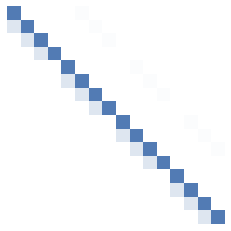

det of equiv matrix 7.705255031585693
true abs determinant 7.705254554748535
true log determinant 2.0419023036956787 



In [16]:
out_channels = 1
in_channels = 1
img_width = 4
img_height = 4

# rand_int = torch.randint(low=0,high=1000,size=(1,))
# print(rand_int)

# 12 seems to be a good seed for a matrix

torch.manual_seed(12)

filter_ = torch.zeros(out_channels, in_channels, 3, 3)
filter_[0,0,1,1] = 1
filter_ = filter_ + torch.randn(out_channels, in_channels, 3, 3) * 0.5

print('Filter')
print(filter_)
print()

equiv_matrix = create_equivalent_matrix(filter_, (1, img_width, img_height))

print(f'det of equiv matrix {torch.det(equiv_matrix)}')

A = equiv_matrix.to(device)

np.save('det_estimate_model/16D/matrix.npy',np.array(A.detach().cpu().numpy()))
np.save('det_estimate_model/16D/filter.npy',np.array(filter_.detach().cpu().numpy()))

print(f'true abs determinant {torch.abs(torch.det(A)).cpu().numpy()}')
print(f'true log determinant {torch.slogdet(A)[1].cpu().numpy()} \n')

### print filter in latex format

In [17]:
# from stackoverflow

def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [18]:
print(bmatrix(np.round(filter_.squeeze().cpu().detach().numpy(),3)))

\begin{bmatrix}
  -0.107 & -0.689 & -0.027\\
  0.226 & 1.393 & -0.544\\
  -0.28 & -0.467 & 0.024\\
\end{bmatrix}


In [19]:
### Learn proposal distribution
NUM_CENTERS = 12
NUM_BINS = 16
NUM_FLOWS_COU = 4
# NUM_DIM_DATA
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 1024


### check invertibility of models

In [10]:
NUM_CENTERS = 1
NUM_BINS = 16
NUM_FLOWS_COU = 4
NUM_DIM_DATA = 8
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 4


cou_spline = Coupling_Flow(num_flows = NUM_FLOWS_COU, 
                          num_dim_data= NUM_DIM_DATA,
                          flow_type = 'moebius', 
                          rezero_flag=False,
                          num_bins = NUM_BINS,
                          num_centers=NUM_CENTERS,
                          cap_householder_refl=CAP_HOUSEHOLDER_REFL)

cou_spline.to(device)

x = torch.randn(BATCH_SIZE, NUM_DIM_DATA)
x = x / torch.norm(x, dim = 1, keepdim = True)

x = x.to(device)

out, ldj, _  = cou_spline(x)

inv, ldj_inv, _ = cou_spline(out,inverse=True)

print('Circle Slice flows')
print(torch.isclose(x,inv,atol=1e-4))
print(torch.mean(torch.abs(ldj+ldj_inv)))
print()

cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                 num_bins=NUM_BINS, 
                                 flow_type='spline',
                                 num_dim_data=NUM_DIM_DATA, 
                                 mask_type='coupling',
                                 rezero_flag=False, 
                                 num_centers=NUM_CENTERS)

cyl_cou_moeb.to(device)

x = torch.randn(BATCH_SIZE, NUM_DIM_DATA)
x = x / torch.norm(x, dim = 1, keepdim = True)

x = x.to(device)

out, ldj, _  = cyl_cou_moeb(x)

inv, ldj_inv, _ = cyl_cou_moeb(out,inverse=True)

print('Cylindrical flows')
print(torch.isclose(x,inv,atol=1e-4))
print()
print(torch.mean(torch.abs(ldj+ldj_inv)))

Circle Slice flows
tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]], device='cuda:0')
tensor(2.3916e-06, device='cuda:0', grad_fn=<MeanBackward0>)

Cylindrical flows
tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]], device='cuda:0')

tensor(1.5557e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [51]:
### define training function
# first to device, then optimizer

def get_log_f_s(A, s):
    """Calculate  -log f(s) with s ~ q"""
    
    dim = A.shape[0]
    s = s.unsqueeze(-1)

    return - dim * torch.log(torch.norm(torch.matmul(A, s).squeeze(-1), dim=1))
    

def get_mean_neg_ELBO(ldj, log_f_s, log_surface):
    """Calculate KL divergence according to 22.1"""    
    return torch.mean( - ldj - log_f_s)


def train_model(model, 
                optimizer, 
                path,
                A, 
                model_name, 
                max_iter = int(1e3), 
                ELBO_list=None, 
                dj_list=None):

    path_ = f'det_estimate_model/{path}'
    os.makedirs(path, exist_ok=True)
    
    A = A.to(device)
    dim = A.shape[0]
    
    if ELBO_list is None and dj_list is None:
        ELBO_list = []
        dj_list = []
    elif ELBO_list is not None and dj_list is not None:
        ELBO_list = list(ELBO_list)
        dj_list = list(dj_list)
    else:
        raise Exception('Elbo list and dj list have to be both none or not none')
        
        
    log_surface = log_surface_hypersphere(n_dim_sphere = A.shape[0] - 1, r = 1)

    for iter_ in range(len(ELBO_list), max_iter):

        s_0 = torch.randn(BATCH_SIZE, dim).to(device)
        s_0 = s_0 / torch.norm(s_0, dim = 1, keepdim=True) 
        s_0.requires_grad = True

        optimizer.zero_grad()

        s, ldj, _ = model(s_0)

        log_f_s = get_log_f_s(A, s)

        neg_ELBO = get_mean_neg_ELBO(ldj, log_f_s, log_surface)

        neg_ELBO.backward()
        optimizer.step()

        ELBO_list.append(neg_ELBO)

        if iter_ % 10 == 0:
            print(f'at iter {iter_} ELBO loss metric {neg_ELBO}')

        if iter_ % 100 == 0:    
            
            s_0 = torch.randn(int(1e5), dim).to(device)
            s_0 = s_0 / torch.norm(s_0, dim = 1, keepdim=True) 
            
            with torch.no_grad():
                
                _, ldj, _ = model(s_0)
                
            dj_list.append(ldj.exp().mean())

            print(f'\n ldj check {ldj.exp().mean()} \n')            

        # plot stuff
        if iter_ % 200 == 0 and iter_ != 0:
            print(f'Iter {iter_}')
            
            plt.plot(range(len(ELBO_list)), ELBO_list)        
            plt.show()
            plt.plot(range(len(dj_list)), dj_list)        
            plt.show()

        if iter_ % 200 == 0:
            
            print("\n ### SAVE MODEL ### \n")
            
            state = {
                'iter_': iter_,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }                        

#             torch.save(state, f"{path_}/{model_name}.t7") 
            
            import numpy as np
            
#             np.save(f"{path_}/ELBO_list_{model_name}.npy",np.array(ELBO_list))
#             np.save(f"{path_}/dj_list_{model_name}.npy",np.array(dj_list))

        

---

### train here 16 x 16 matrix 
### seperately for Circle Slice and Cylindrical Flows

In [52]:
### have to set A = equiv_matrix before starting
A = equiv_matrix

In [53]:
NUM_CENTERS = 12
NUM_BINS = 16
NUM_FLOWS_COU = 8

NUM_DIM_DATA = A.shape[0] # = 16
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 1024

In [54]:
### cou cylindrical moebius model
cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                 num_bins=NUM_BINS, 
                                 flow_type='moebius',
                                 num_dim_data=NUM_DIM_DATA, 
                                 mask_type='coupling',
                                 num_centers=NUM_CENTERS)

cyl_cou_moeb.to(device)

optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())

In [55]:
### coupling moebius model 
cou_moeb = Coupling_Flow(num_flows = NUM_FLOWS_COU, 
                              num_dim_data= NUM_DIM_DATA,
                              flow_type = 'moebius', 
                              num_centers = NUM_CENTERS,
                              cap_householder_refl=CAP_HOUSEHOLDER_REFL)

cou_moeb.to(device)

optimizer = optim.AdamW(cou_moeb.parameters())

In [56]:
### train cou cyl moeb
max_iter = int(1e2)
train_model(cyl_cou_moeb, optimizer_cyl_cou, '16D/', A, model_name='cyl_moeb_v5', max_iter = max_iter)

at iter 0 ELBO loss metric 7.847937107086182

 ldj check 1.0000669956207275 


 ### SAVE MODEL ### 

at iter 10 ELBO loss metric 7.8095903396606445
at iter 20 ELBO loss metric 7.843121528625488
at iter 30 ELBO loss metric 7.7621378898620605
at iter 40 ELBO loss metric 7.638239860534668
at iter 50 ELBO loss metric 7.586273193359375
at iter 60 ELBO loss metric 7.70936918258667
at iter 70 ELBO loss metric 7.658946514129639
at iter 80 ELBO loss metric 7.565380096435547
at iter 90 ELBO loss metric 7.660300254821777


In [57]:
max_iter = int(1e2)
train_model(cou_moeb, optimizer, '16D/', A, model_name='cou_moeb_v5', max_iter = max_iter)

at iter 0 ELBO loss metric 7.906770706176758

 ldj check 1.0000050067901611 


 ### SAVE MODEL ### 

at iter 10 ELBO loss metric 7.8771796226501465
at iter 20 ELBO loss metric 7.758141040802002
at iter 30 ELBO loss metric 7.879400253295898
at iter 40 ELBO loss metric 7.836413383483887
at iter 50 ELBO loss metric 7.871979713439941
at iter 60 ELBO loss metric 7.783448219299316
at iter 70 ELBO loss metric 7.878345966339111
at iter 80 ELBO loss metric 7.823988914489746
at iter 90 ELBO loss metric 7.6661200523376465


### load trained model and continue training

In [ ]:

# circle slice flow
cou_moeb = Coupling_Flow(num_flows=NUM_FLOWS_COU, 
                              num_dim_data=NUM_DIM_DATA,
                              flow_type='moebius', 
                              num_centers=NUM_CENTERS,
                              cap_householder_refl=CAP_HOUSEHOLDER_REFL)

cou_moeb.to(device)

optimizer = optim.AdamW(cou_moeb.parameters())

state = torch.load('det_estimate_model/16D/cou_moeb_in_3d_2.t7')


cou_moeb.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])




In [ ]:
ELBO_list = np.load('det_estimate_model/16D/ELBO_list_cou_moeb_v5.npy',allow_pickle=True)
dj_list = np.load('det_estimate_model/16D/dj_list_cou_moeb_v5.npy',allow_pickle=True)

max_iter = int(40e3)
train_model(cou_moeb, 
            optimizer, 
            A, 
            model_name='cou_moeb_v5', 
            max_iter = max_iter,
            ELBO_list = ELBO_list,
            dj_list = dj_list)

In [ ]:
### cou cylindrical moebius model
cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                 num_bins=NUM_BINS, 
                                 flow_type='moebius',
                                 num_dim_data=NUM_DIM_DATA, 
                                 mask_type='coupling',
                                 num_centers=NUM_CENTERS)

cyl_cou_moeb.to(device)

optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())



state = torch.load('det_estimate_model/cyl_cou_moeb_v5.t7')

cyl_cou_moeb.load_state_dict(state['state_dict'])
optimizer_cyl_cou.load_state_dict(state['optimizer'])

In [ ]:

ELBO_list = np.load('det_estimate_model/16D/ELBO_list_cyl_cou_moeb_v5.npy',allow_pickle=True)
dj_list = np.load('det_estimate_model/16D/dj_list_cyl_cou_moeb_v5.npy',allow_pickle=True)

max_iter = int(40e3)
train_model(cyl_cou_moeb, 
            optimizer_cyl_cou, 
            A, 
            model_name='cyl_cou_moeb_v5', 
            max_iter = max_iter,
            ELBO_list = ELBO_list,
            dj_list = dj_list)

---

## 3 x 3 matrix

In [58]:
### train models combined - Circle Slice and Cylindrical Flows

In [59]:
### check det and eigenvalues of of various 3 x 3 matrices
# the seeds correspond to index 0 to 5 in ascending order in /det/estimate_model/3D

seeds = [29, 15, 33, 76, 73]

for i in seeds:
    print(f'seed {i}')
    
    torch.manual_seed(i)
    A = torch.randn(3, 3)

    NUM_DIM_DATA = equiv_matrix.shape[0]
    print(A)


    print(f'true abs determinant {torch.abs(torch.det(A)).cpu().numpy()}')
    print(f'true log determinant {torch.slogdet(A)[1].cpu().numpy()} \n')

    print(torch.eig(A,eigenvectors=False))
    print()

seed 29
tensor([[ 1.1474, -0.1417,  0.4743],
        [ 0.0876,  0.6843,  1.2199],
        [ 0.7503,  1.0337, -0.1682]])
true abs determinant 1.9111394882202148
true log determinant 0.6476997137069702 

torch.return_types.eig(
eigenvalues=tensor([[-1.0679,  0.0000],
        [ 1.0909,  0.0000],
        [ 1.6405,  0.0000]]),
eigenvectors=tensor([]))

seed 15
tensor([[-0.7056,  0.6741, -0.5454],
        [ 0.9107,  1.0682,  0.1424],
        [-1.2754, -0.1769,  1.0084]])
true abs determinant 2.174506902694702
true log determinant 0.7768018841743469 

torch.return_types.eig(
eigenvalues=tensor([[-1.2758,  0.0000],
        [ 1.5401,  0.0000],
        [ 1.1066,  0.0000]]),
eigenvectors=tensor([]))

seed 33
tensor([[ 1.1982, -0.3998, -0.3476],
        [-0.2759, -2.3094, -1.0931],
        [-0.0808,  0.7721, -1.1370]])
true abs determinant 4.386593341827393
true log determinant 1.478553056716919 

torch.return_types.eig(
eigenvalues=tensor([[ 1.2413,  0.0000],
        [-1.7448,  0.6996],
        [

In [49]:

NUM_CENTERS = 12
NUM_BINS = 32
NUM_FLOWS_COU = 6

NUM_DIM_DATA = 3
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 1024


# original list of seeds

def train_both_models_combined(seeds, path):

    for i, seed in enumerate(seeds):

        max_iter = int(2e3)

        print()
        print(f'run {i} with seed {seed}')

        torch.manual_seed(seed)
        A = torch.randn(3, 3)

        NUM_DIM_DATA = A.shape[0]

        print(f'det {torch.det(A)}')

        A = A.to(device)
        print(A)

#         np.save(f'det_estimate_model/{path}/matrix_in_3d_{i}.npy',np.array(A.detach().cpu().numpy()))

        print(f'true abs determinant {torch.abs(torch.det(A)).cpu().numpy()}')
        print(f'true log determinant {torch.slogdet(A)[1].cpu().numpy()} \n')

        print(torch.eig(A,eigenvectors=False))
        print()
        
        integ = np.random.randint(100)
        
        torch.manual_seed(integ)
        
        
        ### cylindrical ar spline model
        cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                         num_bins=NUM_BINS, 
                                         flow_type='spline',
                                         num_dim_data=NUM_DIM_DATA, 
                                         mask_type='autoregressive',
                                         num_centers=NUM_CENTERS)

        cyl_cou_moeb.to(device)

        optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())

        

        train_model(cyl_cou_moeb, 
                    optimizer_cyl_cou,
                    path,
                    A, 
                    model_name=f'cyl_ar_spline_in_3d_{i}', 
                    max_iter = max_iter)    



        ### CSF coupling spline model 
        cou_spline = Coupling_Flow(num_flows = NUM_FLOWS_COU, 
                                      num_dim_data= NUM_DIM_DATA,
                                      flow_type = 'spline', 
                                      num_centers = NUM_CENTERS,
                                      num_bins=NUM_BINS,
                                      cap_householder_refl=CAP_HOUSEHOLDER_REFL)

        cou_spline.to(device)

        optimizer = optim.AdamW(cou_spline.parameters())

        train_model(cou_spline, 
                    optimizer, 
                    path,
                    A, 
                    model_name=f'cou_spline_in_3d_{i}', 
                    max_iter = max_iter)   




run 0 with seed 15
det -2.174506902694702
tensor([[-0.7056,  0.6741, -0.5454],
        [ 0.9107,  1.0682,  0.1424],
        [-1.2754, -0.1769,  1.0084]], device='cuda:0')
true abs determinant 2.174506902694702
true log determinant 0.7768018841743469 

torch.return_types.eig(
eigenvalues=tensor([[-1.2758,  0.0000],
        [ 1.5401,  0.0000],
        [ 1.1066,  0.0000]], device='cuda:0'),
eigenvectors=tensor([], device='cuda:0'))

at iter 0 ELBO loss metric 0.8938379883766174

 ldj check 1.0000147819519043 


 ### SAVE MODEL ### 

at iter 10 ELBO loss metric 0.9672923684120178
at iter 20 ELBO loss metric 0.9077901840209961
at iter 30 ELBO loss metric 0.8985253572463989
at iter 40 ELBO loss metric 0.8611971139907837
at iter 50 ELBO loss metric 0.8686708211898804
at iter 60 ELBO loss metric 0.8894588947296143
at iter 70 ELBO loss metric 0.8551677465438843
at iter 80 ELBO loss metric 0.8517167568206787
at iter 90 ELBO loss metric 0.8646359443664551
at iter 100 ELBO loss metric 0.842911779

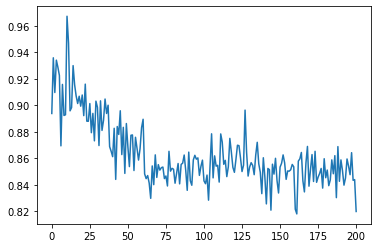

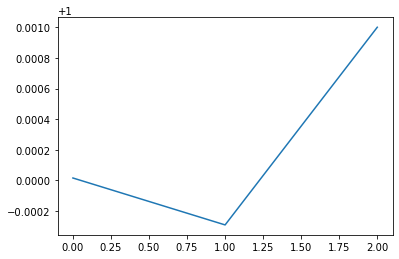


 ### SAVE MODEL ### 



KeyboardInterrupt: 

In [60]:
# we used only the matrix associated to seed 15 in 3D in the VDE paper
seeds = [15]
train_both_models_combined(seeds, path='3D')